# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [8]:
import cv2
import imghdr

In [9]:
data_dir = 'C:/Users/hp/Emotion detection/archive' 

In [10]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        if os.path.isdir(image_path):
            continue
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [17]:
import numpy as np
import random 
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

In [18]:
train_dir = 'C:/Users/hp/Emotion detection/archive/train'
test_dir = 'C:/Users/hp/Emotion detection/archive/test'

img_size = 48
class_labels = []

for num_classes, label in enumerate(os.listdir(train_dir)):
    num_classes += 1
    class_labels.append(label)
    
print(class_labels)
print(f"Num of class: {num_classes}")

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Num of class: 7


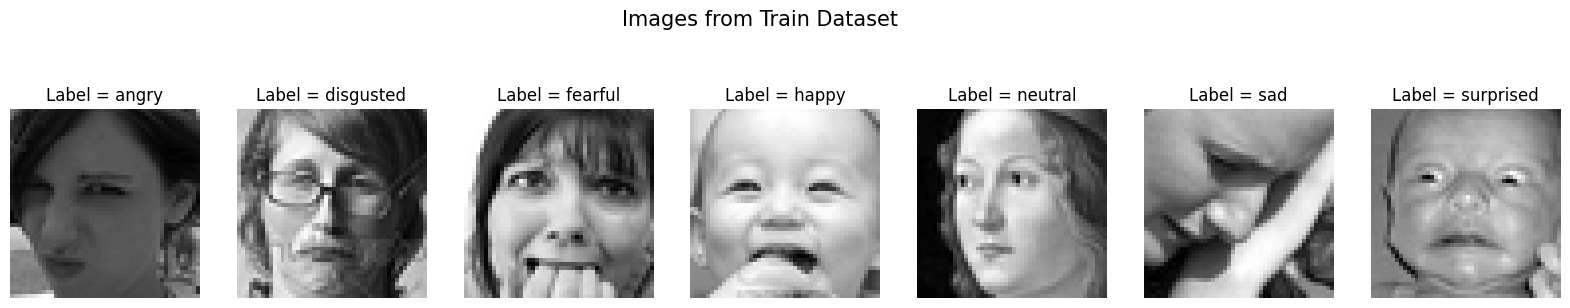

In [19]:
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
fig.suptitle('Images from Train Dataset', fontsize=15)

axes = axes.flatten()

for i, label in enumerate(os.listdir(train_dir)):
    if i == len(axes):
        break
    
    label_path = os.path.join(train_dir, label)
    
    if os.path.isdir(label_path):
        img_file = [f for f in os.listdir(label_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if img_file:
            random_img = random.choice(img_file)
            
            img_path = os.path.join(label_path, random_img)
            
            img = mpimg.imread(img_path)
            
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Label = {label}")
            axes[i].axis('off')

plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_6832\282118680.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_cnt.keys()), y=list(label_cnt.values()), palette=custom_colors)


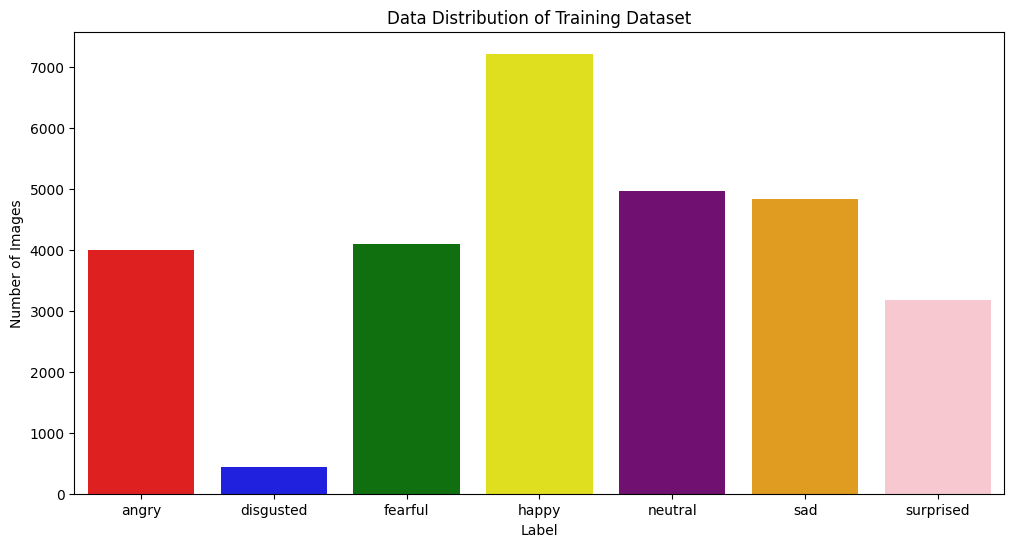

In [20]:
label_cnt = {}

for label in class_labels:
    label_path = os.path.join(train_dir, label)
    num_img = len([f for f in os.listdir(label_path)])
    label_cnt[label] = num_img

plt.figure(figsize=(12, 6))
custom_colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']
sns.barplot(x=list(label_cnt.keys()), y=list(label_cnt.values()), palette=custom_colors)
plt.title('Data Distribution of Training Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.show()

# 4. Preprocessing (Balacing & Preparation)

In [22]:
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
# Balanced sampling to exactly 3000 images per class
filepaths = []
labels = []

target_per_class = 3500

In [24]:
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    images = [os.path.join(label_dir, file) for file in os.listdir(label_dir)
              if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(images)
    if current_count < target_per_class:
        # Oversample
        images = images * (target_per_class // current_count) + random.choices(images, k=(target_per_class % current_count))
    elif current_count > target_per_class:
        # Undersample
        images = random.sample(images, target_per_class)

    filepaths.extend(images)
    labels.extend([label] * target_per_class)

df_balanced = pd.DataFrame({'filepath': filepaths, 'label': labels})
df_balanced = shuffle(df_balanced).reset_index(drop=True)

In [25]:
# Data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filepath',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filepath',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 19600 validated image filenames belonging to 7 classes.
Found 4900 validated image filenames belonging to 7 classes.


C:\Users\hp\AppData\Local\Temp\ipykernel_6832\3606895630.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=custom_colors)


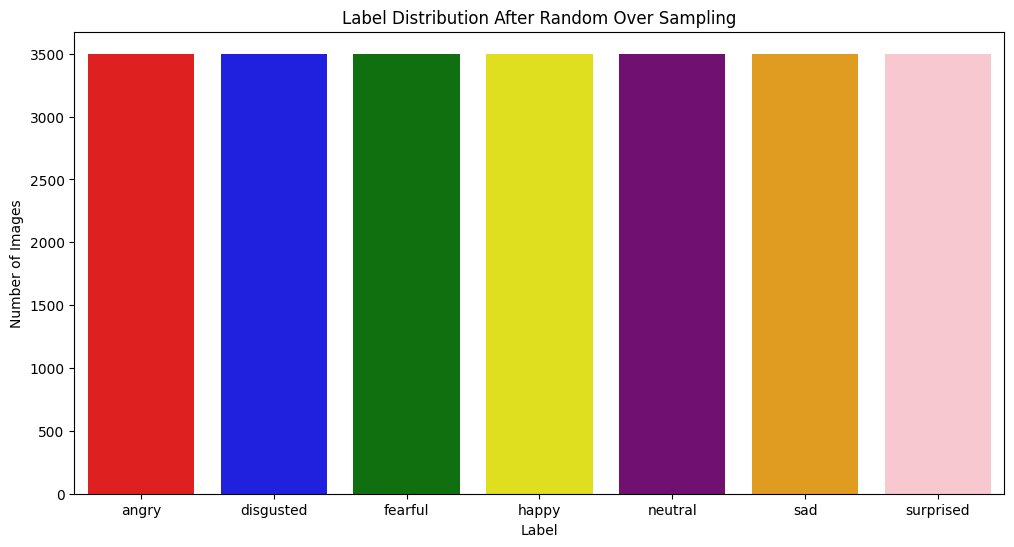

In [26]:
# Check label distribution after balancing
plt.figure(figsize=(12, 6))
custom_colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']
label_counts = df_balanced['label'].value_counts().sort_index()
sns.barplot(x=label_counts.index, y=label_counts.values, palette=custom_colors)
plt.title('Label Distribution After Random Over Sampling')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.show()

# 5. Build Deep Learning Model 

In [28]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Activation, Dropout, MaxPooling2D, Flatten, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from keras import regularizers

In [29]:
model = Sequential([
    # 1st Conv Layer
    Conv2D(32, kernel_size=(3,3), padding='valid', input_shape=(img_size,img_size,1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 2nd Conv Layer
    Conv2D(64, (3,3), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(64, (3,3), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # 4th Conv Layer
    Conv2D(128, (3,3), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(128, (3,3), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation = 'softmax')
])

# Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 64)       2

# 6. Train

In [34]:
history = model.fit(x=train_generator, epochs=15, validation_data=validation_generator)

Epoch 1/15
307/307 [==============================] - 110s 354ms/step - loss: 1.9111 - accuracy: 0.2237 - val_loss: 2.0866 - val_accuracy: 0.1408
Epoch 2/15
307/307 [==============================] - 103s 334ms/step - loss: 1.7329 - accuracy: 0.3145 - val_loss: 1.7149 - val_accuracy: 0.3290
Epoch 3/15
307/307 [==============================] - 99s 322ms/step - loss: 1.6017 - accuracy: 0.3750 - val_loss: 1.5178 - val_accuracy: 0.4182
Epoch 4/15
307/307 [==============================] - 111s 362ms/step - loss: 1.4984 - accuracy: 0.4267 - val_loss: 1.5248 - val_accuracy: 0.4092
Epoch 5/15
307/307 [==============================] - 103s 334ms/step - loss: 1.4404 - accuracy: 0.4494 - val_loss: 1.4992 - val_accuracy: 0.4259
Epoch 6/15
307/307 [==============================] - 106s 344ms/step - loss: 1.3710 - accuracy: 0.4808 - val_loss: 1.6228 - val_accuracy: 0.3282
Epoch 7/15
307/307 [==============================] - 103s 334ms/step - loss: 1.3243 - accuracy: 0.5023 - val_loss: 1.3092 - 

# 7. Plot Performance

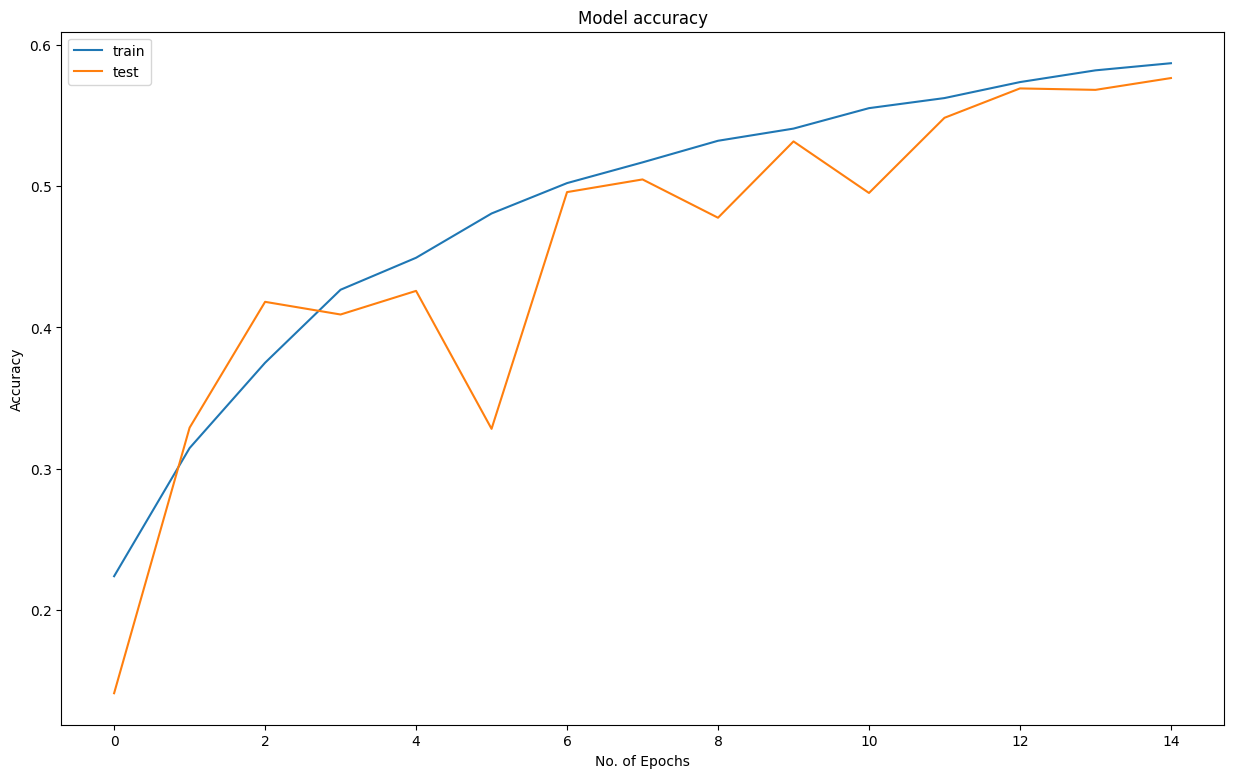

In [36]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

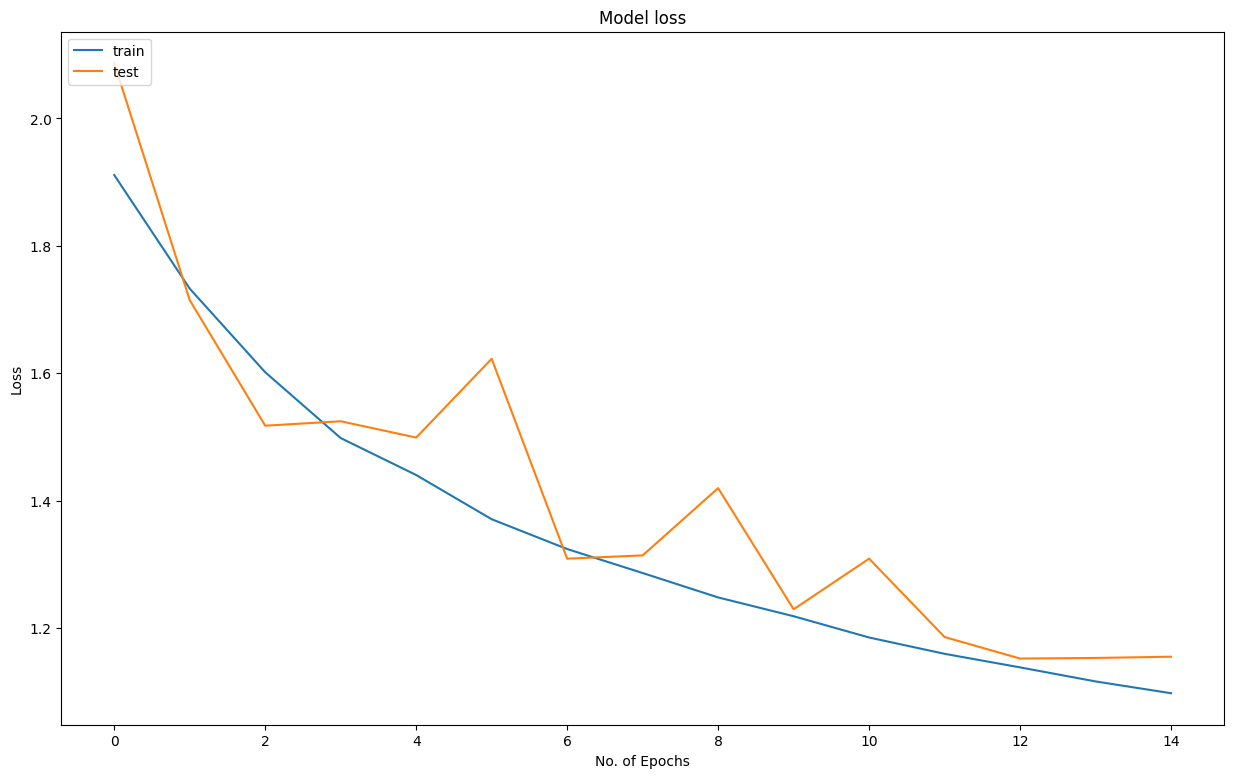

In [37]:
plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 8. Evaluate

Classification Report:
               precision    recall  f1-score   support

       angry       0.43      0.50      0.46       707
   disgusted       0.70      0.93      0.80       722
     fearful       0.48      0.11      0.18       690
       happy       0.64      0.82      0.72       690
     neutral       0.48      0.51      0.49       692
         sad       0.49      0.28      0.36       703
   surprised       0.65      0.85      0.73       696

    accuracy                           0.57      4900
   macro avg       0.55      0.57      0.53      4900
weighted avg       0.55      0.57      0.54      4900



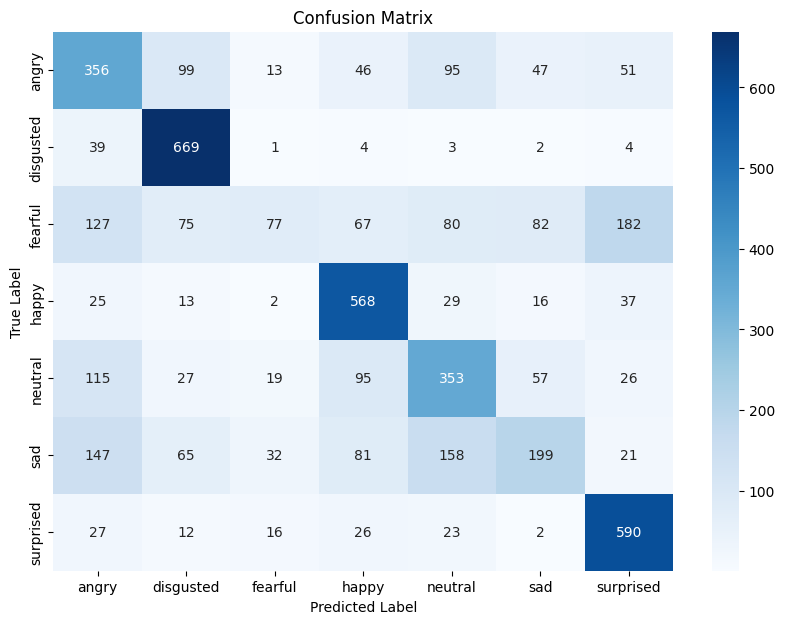

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Get the true labels and predictions
y_true = validation_generator.classes  # True labels
y_pred = model.predict(validation_generator)  # Model predictions

# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate the classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 9. Test

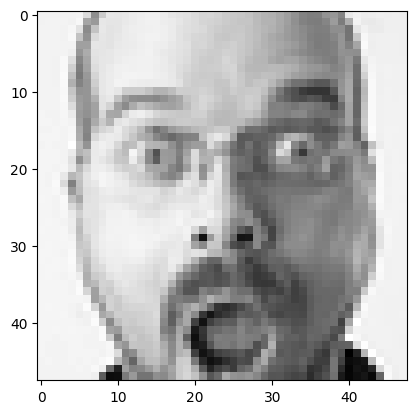

Prediction Probabilities: [[8.4995216e-04 6.2349135e-09 3.5367623e-02 5.0998220e-05 1.7700346e-05
  3.1189244e-05 9.6368247e-01]]
Predicted Class: Surprise


In [45]:
import cv2

class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

img = cv2.imread('im55.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img, (48, 48))

img_normalized = img_resized / 255.0

img_final = np.expand_dims(img_normalized, axis=(0, -1))

plt.imshow(img_resized, cmap='gray')
plt.show()

yhat = model.predict(img_final)
    
predicted_class = np.argmax(yhat)
predicted_label = class_labels[predicted_class]

print(f"Prediction Probabilities: {yhat}")
print(f"Predicted Class: {predicted_label}")

# 10. Save the Model

In [48]:
model.save("fer.h5")

In [49]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("C:/Users/hp/Emotion detection/Facial Expression Recognition.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

# 11. Making Prediction in a Real-Time

In [1]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

#load model
model = model_from_json(open("C:/Users/hp/Emotion detection/Facial Expression Recognition.json", "r").read())
#load weights
model.load_weights('fer.h5')


face_haar_cascade = cv2.CascadeClassifier("C:/Users/hp/Emotion detection/haarcascade_frontalface_default.xml")


cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>

In [2]:
git init

SyntaxError: invalid syntax (2830201818.py, line 1)